## Seq2Seq for translation
Based on [Fastai L11](https://github.com/fastai/fastai/blob/master/courses/dl2/translate.ipynb).
We will translate questions from French into English. 
In this problem, the interesting part are in the architecture.
See [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215)

In [1]:
import time
t0 = time.clock()
time.ctime(time.time())

'Sun May 13 21:45:23 2018'

In [2]:
import torch
torch.__version__

'0.3.0.post4'

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Data
We need $(x, y)$ pairs. Here $x:$ French sentence, and $y:$ the equivalent English sentence.  
We need lots of these $(x, y)$ tuples, a *“parallel corpus”*. 
For a language model, we just need text. 
For translation, there are good parallel corpus available for some languages, 
e.g., European Parliament, UN, etc. 
For French to English, any semi-official Canadian website will have both French and English versions.

### Translation files

In [4]:
from fastai.text import *

French/English parallel texts from http://www.statmt.org/wmt15/translation-task.html, used *a set of simple heuristics to transform French URLs onto English URLs* (i.e. replacing "fr" with "en" and about 40 other hand-written rules), and assume that these documents are translations of each other.

In [5]:
PATH = Path('data/translate')
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)
fname='giga-fren.release2.fixed'
en_fname = PATH/f'{fname}.en'
fr_fname = PATH/f'{fname}.fr'

Training a translation model takes a long time. To simplify [23:22], let’s only learn to translate French questions into English questions. Specifically questions that start with what/where/which/when. 
Below regex looks for things that start with “wh” and end with a question mark.
We use Python's `re` module, which provides regular expression matching operations similar to those found in Perl.
Regular expressions are compiled into pattern objects, which have methods for various operations such as searching for pattern matches or performing string substitutions.

In [6]:
re_eq = re.compile('^(Wh[^?.!]+\?)')
re_fq = re.compile('^([^?.!]+\?)')

We go through the parallel corpus [23:43].
open up each of the two files, where each line is one parallel text and zip them:<br>
`zip(open(en_fname, encoding='utf-8'), open(fr_fname, encoding='utf-8'))`.<br>
then check every pair to see whether they match the regular expressions for questions.  
If they do match, then we grab the lines.
Finally, we collect into `qs` all the lines where we have English and French questions:

In [7]:
lines = ((re_eq.search(eq), re_fq.search(fq)) 
         for eq, fq in zip(open(en_fname, encoding='utf-8'), open(fr_fname, encoding='utf-8')))

qs = [(e.group(), f.group()) for e,f in lines if e and f]

`qs` now contains the tuples of French and English [24:48].
We now have 52K sentence pairs of Wh questions. Some examples:

In [8]:
len(qs), qs[:5]

(52331,
 [('What is light ?', 'Qu’est-ce que la lumière?'),
  ('Who are we?', 'Où sommes-nous?'),
  ('Where did we come from?', "D'où venons-nous?"),
  ('What would we do without it?', 'Que ferions-nous sans elle ?'),
  ('What is the absolute location (latitude and longitude) of Badger, Newfoundland and Labrador?',
   'Quelle sont les coordonnées (latitude et longitude) de Badger, à Terre-Neuve-etLabrador?')])

Dump `qs` as a pickle so we don’t have to do it again. 

In [9]:
pickle.dump(qs, (PATH/'fr-en-qs.pkl').open('wb'))

In [10]:
qs = pickle.load((PATH/'fr-en-qs.pkl').open('rb'))

The what/who/where type questions tend to be fairly short [24:08]. 
Goal is to learn to translate arbitrary Wh questions, with no previous understanding of language.  
50K sentences is very little data for such a complex exercise, would be impressive if we make progress. 
Handy idiom to split them apart into 2 lists: English and French questions.

In [11]:
en_qs,fr_qs = zip(*qs)

Tokenize the English and the French questions. 
Tokenize just means splitting them up into separate words or "word-like" things. 
By default [25:11], the tokenizer (a wrapper around the spaCy tokenizer) assumes English. 
For French, add an extra parameter 'fr'. 
The first time you may get an error (need spaCy French model installed).
To download the models:<br>
`python -m spacy download fr` <br>
`python -m spacy download en` <br>

In [16]:
en_tok = Tokenizer.proc_all_mp(partition_by_cores(en_qs))

fr_tok = Tokenizer.proc_all_mp(partition_by_cores(fr_qs), 'fr')

If you have RAM use problems, check `proc_all_mp()`, its processing every sentence across multiple CPUs [25:59]: 

Lets see the English and French tokens on a sentence.  

In [17]:
en_tok[0], fr_tok[0]

(['what', 'is', 'light', '?'],
 ['qu’', 'est', '-ce', 'que', 'la', 'lumière', '?'])

Tokenization for French is quite different: French love apostrophes and hyphens. 
An English tokenizer for a French sentence would be bad. 
**Always use the right language tokenizer** [28:23]. 

Save to disk. 
Next turn the tokens into numbers by:
1. get a list of all of the words that appear 
2. turn every word into the index. 

If more than 40K words appear cut it off there. 

In [18]:
len(en_tok), len(fr_tok)

(52331, 52331)

Lets see what % of the sentences are above certain length.
For the 95 percentile, the English sentences are less than 28 tokens, and the French less than 34.
For the 97 percentile, the English sentences are less than 32 tokens, 
For the 96 the French sentences are less than 36 tokens.

In [19]:
np.percentile([len(o) for o in en_tok], 95), np.percentile([len(o) for o in fr_tok], 95)

(28.0, 34.0)

In [20]:
np.percentile([len(o) for o in en_tok], 97), np.percentile([len(o) for o in fr_tok], 96)

(32.0, 36.0)

So we decide to keep all the sentence pairs that have less than 30 tokens in English

In [21]:
keep = np.array([len(o)<30 for o in en_tok])

In [22]:
en_tok = np.array(en_tok)[keep]
fr_tok = np.array(fr_tok)[keep]
len(en_tok), len(fr_tok)

(50260, 50260)

Now we are left with 50K pairs, lets pickle save them.

In [23]:
pickle.dump(en_tok, (PATH/'en_tok.pkl').open('wb'))
pickle.dump(fr_tok, (PATH/'fr_tok.pkl').open('wb'))

en_tok = pickle.load((PATH/'en_tok.pkl').open('rb'))
fr_tok = pickle.load((PATH/'fr_tok.pkl').open('rb'))

We insert a few extra tokens for beginning of stream (\_bos_), padding (\_pad_), end of stream (\_eos_), and unknown (\_unk). So if we look up something that wasn’t in the 40,000 most common, then we use a `defaultdict` to return 3 which is unknown.

In [24]:
def toks2ids(tok, pre):
    freq = Counter(p for o in tok for p in o)
    itos = [o for o,c in freq.most_common(40000)]
    itos.insert(0, '_bos_')  # begin of sentence
    itos.insert(1, '_pad_')  # padding
    itos.insert(2, '_eos_')  #end of sentence
    itos.insert(3, '_unk')   #unknown
    stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    ids = np.array([([stoi[o] for o in p] + [2]) for p in tok])
    np.save(TMP_PATH/f'{pre}_ids.npy', ids)
    pickle.dump(itos, open(TMP_PATH/f'{pre}_itos.pkl', 'wb'))
    return ids,itos,stoi

Now we can convert every token into an ID by using the `stoi` dictionary, and of each sentence we add [2] the _eos_ token.  
[32:01]
Now we have for later:
- `PRE_ids` a list of IDs 
- `PRE_itos` the vocabulary 
- `PRE_stoi` reverse mapping  

In [25]:
en_ids,en_itos,en_stoi = toks2ids(en_tok,'en')
fr_ids,fr_itos,fr_stoi = toks2ids(fr_tok,'fr')
len(en_itos), len(fr_itos)

(17573, 24793)

English (French) vocabs are 17K and 25K. Not too big. 

In [26]:
def load_ids(pre):
    ids = np.load(TMP_PATH/f'{pre}_ids.npy')
    itos = pickle.load(open(TMP_PATH/f'{pre}_itos.pkl', 'rb'))
    stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    return ids,itos,stoi

In [27]:
en_ids,en_itos,en_stoi = load_ids('en')
fr_ids,fr_itos,fr_stoi = load_ids('fr')

To confirm it’s working, we go through each ID and convert the int to a string.
There is the sentence, now with an \_eos_ marker at the end. 

In [28]:
[fr_itos[o] for o in fr_ids[0]], 

(['qu’', 'est', '-ce', 'que', 'la', 'lumière', '?', '_eos_'],)

### Word vectors
We will like to use language models... :-) But now all we have is word vectors.
`Word2vec` is old. `fast.text` is a good source of word vectors, with hundreds of languages available.

Get them from: [fasttext word vectors](https://fasttext.cc/docs/en/english-vectors.html)

#!pip install git+https://github.com/facebookresearch/fastText.git

In [29]:
import fastText as ft

To use the fastText library, download the [fasttext word vectors](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md) for your language (download the 'bin plus text' ones).<br>
!wget https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.zip <br>
!wget https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.zip <br>
!unzip wiki.*.zip

In [30]:
en_vecs = ft.load_model(str((PATH/'wiki.en.bin')))

fr_vecs = ft.load_model(str((PATH/'wiki.fr.bin')))

Above are English and French models, in both text and binary versions. 
Choose the faster binary, (text version is a bit buggy). 
Convert it to a Python dictionary. [35:55]. 
`get_vecs()` goes through each word with a dictionary comprehension and then pickle saves it.

In [31]:
def get_vecs(lang, ft_vecs):
    vecd = {w:ft_vecs.get_word_vector(w) for w in ft_vecs.get_words()}
    pickle.dump(vecd, open(PATH/f'wiki.{lang}.pkl','wb'))
    return vecd

In [32]:
en_vecd = get_vecs('en', en_vecs)
fr_vecd = get_vecs('fr', fr_vecs)

en_vecd = pickle.load(open(PATH/'wiki.en.pkl','rb'))
fr_vecd = pickle.load(open(PATH/'wiki.fr.pkl','rb'))

#Debug code...
ft_words = ft_vecs.get_words(include_freq=True)    #ft_vec should be en_vecd or fr_vecd
ft_word_dict = {k:v for k,v in zip(*ft_words)}
ft_words = sorted(ft_word_dict.keys(), key=lambda x: ft_word_dict[x])

len(ft_words)

In [33]:
#Lets look at a word, e.g. comma, and print the size of the vector
dim_en_vec = len(en_vecd[','])
dim_fr_vec = len(fr_vecd[','])
dim_en_vec,dim_fr_vec

(300, 300)

We also need the mean and standard deviation of the vectors, i.e., mean is about zero and standard deviation is about 0.3.

In [34]:
en_vecs = np.stack(list(en_vecd.values()))
en_vecs.mean(),en_vecs.std()  #will need it later....

(0.0075652334, 0.29283327)

### Model data

#### Truncate long tail
Corpuses have a long tailed distribution of sequence length.
The longest sequences overwhelm performance (time, RAM). 
So we grab the 99th to 97th percentile of the English and French and truncate them to that amount.

In [35]:
enlen_90 = int(np.percentile([len(o) for o in en_ids], 99))
frlen_90 = int(np.percentile([len(o) for o in fr_ids], 97))
enlen_90,frlen_90

(29, 33)

Sentences up to 29 and 33 tokens long.

In [36]:
en_ids_tr = np.array([o[:enlen_90] for o in en_ids])
fr_ids_tr = np.array([o[:frlen_90] for o in fr_ids])

We have tokenized, numericalized English and French dataset, and word vectors. 
PyTorch expects a Dataset object (ie — a length (\__len__) and an indexer (__getitem__).

**NB:** The seq2seq example at the pytorch tutorials demo overfits, it is bad.
another example of bad code is the lack of use of adaptive pooling in convenets.
If the repo does not have a section with a test that validates that it can reproduces the results of the paper...

In [37]:
class Seq2SeqDataset(Dataset):
    def __init__(self, x, y): self.x,self.y = x,y
    def __getitem__(self, idx): return A(self.x[idx], self.y[idx])
    def __len__(self): return len(self.x)

`A` : Numpy Arrays. It will go through each of the thing you pass it, if it is not already a numpy array, it converts into a numpy array and returns back a tuple of all of the things you passed it, 
which are now guaranteed to be numpy arrays [38:32].

#### Training set and validation set 
Now we need to grab our English and French IDs and get a training set and a validation set. 

Here is an easy way to get training and validation sets [42:45]. Get random numbers — one for each row of your data, and see if they are bigger than 0.1 or not. That gets you a list of booleans, `trn_keep`. 
Index into your array with `trn_keep` (`~trn_keep`) to grab a training (validation) set.

In [38]:
np.random.seed(42)
trn_keep = np.random.rand(len(en_ids_tr))>0.1
en_trn,fr_trn = en_ids_tr[trn_keep],fr_ids_tr[trn_keep]
en_val,fr_val = en_ids_tr[~trn_keep],fr_ids_tr[~trn_keep]
len(en_trn),len(en_val)

(45219, 5041)

Now create our dataset with X’s and Y’s (i.e. French and English)[43:12]. 
(To translate instead English to French, switch these two around).

In [39]:
trn_ds = Seq2SeqDataset(fr_trn,en_trn)
val_ds = Seq2SeqDataset(fr_val,en_val)

Now we need to create DataLoaders [43:22]. 
We can use the data loader and pass in our dataset and batch size. 
But we have to **transpose the arrays**.
As the pre-processing is done, no need for multiple workers to do augmentation, etc.
So `num_workers=1` saves time. 

Remember a tensor has to be rectangular.
So we have to tell it what our padding index is — important because we’ve got different length sentences.
automatically fastai will stick them together and pad the shorter ones so that they are all equal length. 

In [40]:
bs=125

#### Sampler - Sortish and Sort
[44:54] 
We have sentences of different lengths coming in. They have to be together in a mini-batch to be the same size by padding. Is better if the sentences in a mini-batch are of similar sizes. 
Otherwise they will be as long as the longest sentence in each, wasting time and memory. 
Therefore, we use `SortSampler`, for the validation set, will sort everything by length first. 
Then for the training set, `SortishSampler` will randomize the order 
but roughly make it so that things of similar length are about in the same spot.

In [41]:
trn_samp = SortishSampler(en_trn, key=lambda x: len(en_trn[x]), bs=bs)
val_samp = SortSampler(en_val, key=lambda x: len(en_val[x]))

In the decoder we want our padding to be at the end, not at the start [44:29]:
For a Classifier → padding in the beginning, because we want the final token to represent the last word of the movie review.
For a Decoder → padding at the end works better. 

In [42]:
trn_dl = DataLoader(trn_ds, bs, transpose=True, transpose_y=True, num_workers=1, 
                    pad_idx=1, pre_pad=False, sampler=trn_samp)
val_dl = DataLoader(val_ds, int(bs*1.6), transpose=True, transpose_y=True, num_workers=1, 
                    pad_idx=1, pre_pad=False, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

The ModelData model data object creator simply combines the data loaders for the training set, and defines a PATH for temporary files, etc.
Here we minimize the use of fastai, use mostly pytorch.

Now we are done with the data part. 
Lets just take a peek at the length sizes of the first 5 sentences in the training dataset.

In [43]:
it = iter(trn_dl)
its = [next(it) for i in range(5)]
[(len(x),len(y)) for x,y in its]

[(31, 11), (21, 7), (21, 8), (33, 13), (33, 21)]

## Architecture

In [44]:
from IPython.display import Image
Image(url='https://cdn-images-1.medium.com/max/1400/1*1fKDaDswwVu3w2ZtCg-Uow.png')

We take the sequence of tokens and spit them into an RNN **encoder (a.k.a. backbone)**.
The encoder will spit out the final hidden state ($h$) which, for each sentence, is just a single vector.
(This part is not new [47:41]). 

Then $h$ goes into a $2nd$ RNN, the **decoder**. 
That is new, we need something that can go through one word at a time. 
And it keeps going until it thinks it’s finished the sentence, then it stops and returns a sentence.
It doesn’t know how long the sentence is going to be ahead of time. 

## Initial Model

### Encoder 
Let’s start with the encoder [48:15]. 
For variable naming, there are identical attributes for encoder and decoder. 
The encoder version has `enc`, the decoder has `dec`.

- emb_enc: Embeddings for the encoder
- gru : RNN. GRU and LSTM are nearly the same thing.

We need an embedding layer, as we are passed an index of the words into a vocabulary, 
and we want to grab their fast.text embedding. 
Later, we might want to fine tune to train that embedding end-to-end.

`create_emb` [49:37]:  To set the rows and columns for the embedding: 
Number of rows must be $\equal$ to the vocabulary size — so each token has a word vector. 
*fast.text* determined the size of the embeddings: 300, so we must use size 300 to use their embeddings.

- `nn.Embedding` will initially give us a random set of embeddings [50:12]. 
We will go through each and if we find it in fast.text, we replace it with the fast.text embedding. 

Recall that `emb.weight.data`:

In [45]:
def create_emb(vecs, itos, em_sz):
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    wgts = emb.weight.data  # the weight tensor
    miss = []
    for i,w in enumerate(itos):
        try: wgts[i] = torch.from_numpy(vecs[w]*3)
        except: miss.append(w)
    print(len(miss),miss[5:10])
    return emb

**NB:** *A PyTorch module that is learnable has a weight attribute*, e.g., `wgts = emb.weight.data`.
A weight attribute is a Variable that has data attribute, and the data attribute is a tensor.

Now that we’ve got our weight tensor, we go through our vocabulary 
```
for i,w in enumerate(itos):
```
We look up the word in our pre-trained vectors and if we find it, 
we replace the random weights with that pre-trained vector [52:35]. 

The random weights have a standard deviation of 1. 
Our pre-trained vectors has a standard deviation of about 0.3. 
As a prototyping hack, JH just multiplied it by 3 (`vecs[w] * 3$`). 
TODO: fix this...

Some things won’t be in fast.text in which case, we’ll just keep track of it [53:22]. 
The print statement is there so that we can see what’s going on (i.e. why are we missing stuff?). 
We missed a few of the 30K... not too many.

In [46]:
nh,nl = 256,2

The encoder takes the inputs and spits out a hidden vector that (hopefully) will learn to contain all of the information about what that sentence says and how [58:49]. 
That is a pre-requisite, else the decoder can't translate...  
So that’s what we want it to learn to do. 
As usual, we are going to do the (data, architecture, loss function) and hope.

### Decoder 
[59:58]: 
Same idea, but we are going to write our own for-loop. 
The for-loop will do exactly what the for-loop inside PyTorch does for the encoder, 
but we are going to do it manually. 
How big is the for loop? 
It’s an output sequence length (`out_sl`) which was something passed to the constructor, 
and is the length of the largest English sentence. 
Since we are translating into English, it can’t possibly be longer than that in this corpus. 
If we used it on a longer (different) corpus, this is going to fail...— but we could pass in a different parameter.

[1:01:06].
We are going to go through and put it through the embedding.
We are going to stick it through the RNN, dropout, and a linear layer.
We will then append the output to a list which will be stacked into a single tensor and get returned.

Normally, a RNN works on a whole sequence at a time, but we have a for loop to go through each part of the sequence separately [1:01:37]. 
So we have to add a leading unit axis to the start (`.unsqueeze(0)`) 
to say this is a sequence of length one. 
In fact, we are not really taking advantage of the RNN — we could easily re-write this with a linear layer.

One thing to be aware of is `dec_inp` [1:02:34]: 
*What is the input to the embedding?* 
It is the previous word that we translated. 
Translating the $n$ word of a sentence without knowledge of the $n-1$ word is really hard. 
So we are going to feed it at each time step. 
What was the previous word at the start? There was none. 

Specifically, we are going to start out with a beginning of stream token (_bos_) which is zero.
[1:05:24]:
- `outp`  it is a tensor whose length is equal to the number of words in the English vocabulary and it contains the probability for every one of those words that it is that word.

- `outp.data.max()` : It looks in its tensor to find out which word has the highest probability. 
`max()` in PyTorch returns two things: (1) the max probability and (2) the index into the array. 
We want (2), which is the word index of the largest probability.

- `dec_inp` : the word index into the vocabulary. 
If it’s $1$ (i.e. padding), that means we are done — we reached the end. 
If it’s not $1$, let’s go back and continue.

Each time, we appended our outputs (not the word but the probabilities) to the list `res` [1:06:48] which we stack up into a tensor and we can now go ahead and return `torch.stack(res)` to feed that to a loss function.

In [47]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        
    def forward(self, inp):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = self.out_enc(h)

        dec_inp = V(torch.zeros(bs).long())
        res = []
        for i in range(self.out_sl):
            emb = self.emb_dec(dec_inp).unsqueeze(0)
            outp, h = self.gru_dec(emb, h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
        return torch.stack(res)
    
    def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))

### Loss function 
[1:07:13] The loss function is (basically) Categorical Cross Entropy Loss (with 2 tweaks). 
We have a list of probabilities for each of our classes. 
The classes are all the words in our English vocab.
The target is the correct class (i.e. which is the correct word at this location). 

In [48]:
def seq2seq_loss(input, target):
    sl,bs = target.size()
    sl_in,bs_in,nc = input.size()
    if sl>sl_in: input = F.pad(input, (0,0,0,0,0,sl-sl_in))
    input = input[:sl]
    return F.cross_entropy(input.view(-1,nc), target.view(-1))#, ignore_index=1)

But there are 2 Tweaks, so we had to write our own loss function. (basically it is cross entropy loss).
[1:07:40]:

1. If the generated sequence length is shorter than the sequence length of the target, we need to add some padding. 
PyTorch padding function is weird... requires a 6-tuple to pad a rank 3 tensor (sequence length, batch size, by number of words in the vocab). Each pair represents padding before and after that dimension.
2. `F.cross_entropy` expects a rank 2 tensor, but we have sequence length by batch size, so just flatten out. 
That is what `.view(-1, ...)` does.

In [49]:
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

The difference between .cuda() and to_gpu() : to_gpu will not put to in the GPU if you do not have one. 
**NB: set fastai.core.USE_GPU to False to force it to not use GPU** handy for debugging.

In [50]:
rnn = Seq2SeqRNN(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

3097 ['l’', "d'", 't_up', 'd’', "qu'"]
1285 ["'s", '’s', "n't", 'n’t', ':']


We need something that tells it how to handle learning rate groups. 
The easiest way to turn a PyTorch module into a fastai model is using `SingleModel`. 
You can pass to `SingleModel()` the whole thing as a single learning rate group [1:09:40]. 

We could just call Learner to turn that into a learner, instead of RNN_Learner.
But RNN_Learner adds in `save_encoder` and `load_encoder` that can be handy sometimes. 
In this case, we really could have said Learner but RNN_Learner also works.

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 64%|██████▍   | 231/362 [00:33<00:18,  6.90it/s, loss=33.9]

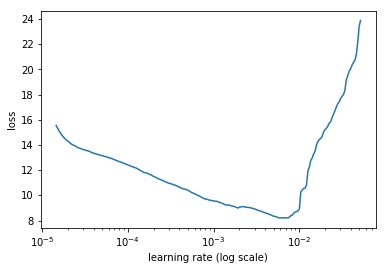

In [51]:
learn.lr_find()
learn.sched.plot()

In [52]:
lr=3e-3

In [53]:
cle1 = learn.fit(lr, 1, cycle_len=15, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

 12%|█▏        | 42/362 [00:06<00:46,  6.83it/s, loss=8.88]

Exception in thread Thread-8:
Traceback (most recent call last):
  File "/home/german/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/german/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/german/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                              
    0      5.186482   5.608422  
    1      4.375876   4.47572                               
    2      3.928583   4.199362                              
    3      3.650999   3.915671                              
    4      3.466414   3.763817                              
    5      3.38536    3.669423                              
    6      3.031949   3.606027                              
    7      2.977798   3.580452                              
    8      3.000535   3.526985                              
    9      3.053902   3.606001                              
    10     2.696597   3.514466                              
    11     2.688112   3.505063                              
    12     2.632034   3.490269                              
    13     2.492173   3.476649                              
    14     2.536312   3.508378                              



In [54]:
learn.save('initial')

learn.load('initial')

### Test

 [1:11:01]
Remember the model attribute of a learner is a standard PyTorch model so we can pass some $x$ which we can grab out of our validation set. 
Or you could `learn.predict_array` to get some predictions. 
Then we convert those predictions into words by going `.max()[1]` to grab the index of the highest probability words to get some predictions. 
Then for a few examples lets print the French, the correct English, and the predicted English,
for things that are not padding.

In [55]:
x,y = next(iter(val_dl))
probs = learn.model(V(x))
preds = to_np(probs.max(2)[1])

for i in range(170,180):
    print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in preds[:,i] if o!=1]))
    print()

que considérez - vous comme les lacunes / besoins clés transversaux et dans des domaines précis de la recherche en hygiène de l’ environnement au canada ? _eos_
what do you consider to be the key issue - specific and cross - cutting gaps / needs in environmental health research in canada ? _eos_
what do you see as the key issues and issues in in in in in canada canada research canada ? ? ? _eos_

que faire si le crédit pour la t_up tps / t_up tvh de l’ époux ou conjoint de fait survivant comprend un montant pour la personne décédée ? _eos_
what if the surviving spouse ’s or common - law partner ’s t_up gst / t_up hst credit includes a claim for the deceased ? _eos_
what if the deceased 's t_up t_up / t_up / / / hst hst or or or deceased or deceased or law ? ? ? ? _eos_

quelle est la validité d' un paiement qui est soit dérisoire , soit sans rapport avec le coût de production du médicament offert comme échantillon ? _eos_
what is the validity of a payment which is either insignificant 

**NB:** a simple (possible written largely from scratch) PyTorch module, on only 50K sentences is sometimes capable, on a validation set, of giving the right answer. 
Not perfect, sometimes slightly different wording, 
and sometimes sentences that aren’t grammatically sensible, or have too many question marks. 
But we are on the right track. 
Even the simplest possible seq-to-seq trained for a small number of epochs without any pre-training 
(other than the use of word embeddings) is surprisingly good. 

So a simple seq-to-seq model with little data is surprisingly effective, and in certain situations this may be enough for our needs. [1:13]

## Bidir

### Trick #1 : Go bi-directional
For classification, the approach to bi-directional is take all of your token sequences, spin them around, train a new language model, and train a new classifier. 
JH mentioned that in the wikitext pre-trained model if you replace fwd with bwd in the name, you will get the pre-trained backward model he created for you. 
Get a set of predictions and then average the predictions just like a normal ensemble. 
That is how we do bi-dir for that kind of classification. 
There may be ways to do it end-to-end, but JH hasn’t quite figured them out, so they are not in fastai yet. 
So if you figure it out, that’s an interesting line of research. 

But because we are not doing massive documents where we have to chunk it into separate bits and then pool over them, we can do bi-dir very easily in this case. 
It is literally as simple as adding bidirectional=True to our encoder. 
People tend not to do bi-dir for the decoder partly because it is *kind of considered cheating*...
But maybe it can work in some situations although it might need to be more of an ensemble approach in the decoder because it’s a bit less obvious. 

But encoder is simple — `bidirectional=True` and we have a $2nd$ RNN that is going in the opposite direction.
The $2nd$ RNN is visiting each token in the opposing order, so when we get to the final hidden state, it is the first (i.e. left most) token. 
But the hidden state is the same size, so the final result is that we end up with a tensor with an extra axis of length 2. 

NB: Depending on the library, often that will be then combined with the number of layers, 
so if you have 2 layers and bi-directional — that tensor dimension is now length 4. 
With PyTorch it depends which bit of the process you are looking at as to whether you get a separate result for each layer and/or for each bidirectional bit. 
The documentation will tell the input’s output’s tensor sizes appropriate for the number of layers and whether you have bidirectional=True.

In this particular case, you will see all the changes that had to be made [1:19:38]. 
For example, when we added `bidirectional=True`, the Linear layer now needs number of hidden times 2 (i.e. $nh*2$) to reflect that we have that $2nd$ direction in our hidden state. Also in `initHidden` it’s now $self.nl*2$.

In [56]:
class Seq2SeqRNN_Bidir(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25, bidirectional=True)
        self.out_enc = nn.Linear(nh*2, em_sz_dec, bias=False)
        self.drop_enc = nn.Dropout(0.05)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        
    def forward(self, inp):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = h.view(2,2,bs,-1).permute(0,2,1,3).contiguous().view(2,bs,-1)
        h = self.out_enc(self.drop_enc(h))

        dec_inp = V(torch.zeros(bs).long())
        res = []
        for i in range(self.out_sl):
            emb = self.emb_dec(dec_inp).unsqueeze(0)
            outp, h = self.gru_dec(emb, h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
        return torch.stack(res)
    
    def initHidden(self, bs): return V(torch.zeros(self.nl*2, bs, self.nh))

Question: Why use a range to the loop? [1:20:58] 
```
for i in range(self.out_sl):
```
Because when we start training, everything is random so if 
`(dec_inp==1).all(): break` will probably never be true. 
Later on, it will always break, so this is like "forever loop until break". 
NB: At the start, the model knows nothing. 
So we must make sure that it will do something at least vaguely sensible....
See Teacher forcing for this....

In [57]:
rnn = Seq2SeqRNN_Bidir(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

3097 ['l’', "d'", 't_up', 'd’', "qu'"]
1285 ["'s", '’s', "n't", 'n’t', ':']


In [58]:
cle2 = learn.fit(lr, 1, cycle_len=1, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      4.611539   4.401235  



We got {{cle1}} cross entropy loss with single direction [1:21:46], and with bi-direction, {{cle2}}, improved a little. It shouldn’t really slow things down too much. 
Bi-directional does mean there is a little bit more sequential processing have to happen, but it is generally a good win. 
In the Google translation model, of the 8 layers, only the first layer is bi-directional, because it allows it to do more in parallel. 
If we create really deep models, think about which ones are bi-directional otherwise we will have performance issues.

In [59]:
learn.save('bidir')

## Teacher forcing
When a model starts learning, it knows nothing, so it is going to spit out meaningless words,
which are not helpful for the next process as an input.  
Early learning is difficult because it is feeding in an input that is stupid into a model that knows nothing. 
So it is not asking too much eventually it gets there, but it’s definitely not as helpful as we can be. 
Instead, in teacher forcing, we feed in the actual correct word. 
(Of course, we can’t do that at inference time, only during training).

`pr_force` is the probability of forcing [1:24:01]. 
If some random number is less than that probability then we replace our decoder input with the correct (ground truth) word. 
If we have already gone too far and if it is already longer than the target sequence, we are just going to stop. 

Let’s now write something such that in the training loop, it gradually decreases `pr_force` [1:26:01] 
But not from scratch! The fastai training loop already provides convinient things like:
- progress bars, 
- exponential weighted averages to smooth out the losses, 
- keeps track of metrics,  
- keep track of calling the reset for RNN at the start of the epoch to make sure the hidden state is set to zeros. 

So lets just add a "hook", in this case, the `stepper`. model.py is where the `fit` function lives, the lowest level thing that does not require learner — just requires a standard PyTorch model and a model data object. 
You just need to know how many epochs, a standard PyTorch optimizer, and a standard PyTorch loss function. We hardly ever used in the class, we normally call learn.fit, (and learn.fit calls fit).<br>
`stepper.step` is responsible for:
- calling the model
- getting the loss
- finding the loss function
- calling the optimizer

In [60]:
class Seq2SeqStepper(Stepper):
    def step(self, xs, y, epoch):
        self.m.pr_force = (10-epoch)*0.1 if epoch<10 else 0
        xtra = []
        output = self.m(*xs, y)
        if isinstance(output,tuple): output,*xtra = output
        self.opt.zero_grad()
        loss = raw_loss = self.crit(output, y)
        if self.reg_fn: loss = self.reg_fn(output, xtra, raw_loss)
        loss.backward()
        if self.clip:   # Gradient clipping
            nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)
        self.opt.step()
        return raw_loss.data[0]

JH suspects that the above code is too complicated... Probably could have been just:
```
    class Seq2SeqStepper(Stepper):
    def step(self, xs, y, epoch):
        self.m.pr_force = (10-epoch)*0.1 if epoch<10 else 0
        return super.step(xs, y, epoch)
```

[1:25:29]. At the start of training, let’s set `pr_force` high so that nearly always it gets the actual correct previous word. As we train, we decrease `pr_force` all the way to $0$ (here at epoch 10). 
Then it has to learn properly. 

In [61]:
class Seq2SeqRNN_TeacherForcing(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        self.pr_force = 1.
        
    def forward(self, inp, y=None):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = self.out_enc(h)

        dec_inp = V(torch.zeros(bs).long())
        res = []
        for i in range(self.out_sl):
            emb = self.emb_dec(dec_inp).unsqueeze(0)
            outp, h = self.gru_dec(emb, h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
            if (y is not None) and (random.random()<self.pr_force):
                if i>=len(y): break
                dec_inp = y[i]
        return torch.stack(res)
    
    def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))

The following 3 lines were added:
```
    if (y is not None) and (random.random()<self.pr_force):
                if i>=len(y): break
                dec_inp = y[i]
```

In [62]:
rnn = Seq2SeqRNN_TeacherForcing(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

3097 ['l’', "d'", 't_up', 'd’', "qu'"]
1285 ["'s", '’s', "n't", 'n’t', ':']


At least 11 epochs as before then it was "cheating" by getting the right value.

In [63]:
cle3 = learn.fit(lr, 1, cycle_len=12, use_clr=(20,10), stepper=Seq2SeqStepper)

HBox(children=(IntProgress(value=0, description='Epoch', max=12), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      4.109371   10.718476 
    1      3.502335   7.078614                              
    2      3.380031   5.283758                              
    3      2.77675    5.305664                              
    4      2.798407   4.781346                              
    5      2.855621   3.954203                              
    6      2.826146   4.657924                              
    7      2.816177   3.803967                              
    8      2.868588   3.558825                              
    9      3.099182   3.451799                              
    10     2.934879   3.453047                              
    11     2.958333   3.412886                              



In [64]:
learn.save('forcing')

## Attentional model
Attention is cool. 
Expecting the entirety of the sentence to be summarized into this single hidden vector is asking a lot. 
It has to know what was said, how it was said, and everything necessary to create the sentence in the 2nd language.  

Lets use a model where we output a hidden state **after every single word**. 
That information (hidden states) is already there but we’ve just been throwing it away. 
Not only that but bi-directional, we got two vectors of state every step that we can use. <br>
How can we do this?

In [65]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

In [66]:
class Seq2SeqAttnRNN(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec*2, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data

        self.W1 = rand_p(nh, em_sz_dec)
        self.l2 = nn.Linear(em_sz_dec, em_sz_dec)
        self.l3 = nn.Linear(em_sz_dec+nh, em_sz_dec)
        self.V = rand_p(em_sz_dec)

    def forward(self, inp, y=None, ret_attn=False):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = self.out_enc(h)

        dec_inp = V(torch.zeros(bs).long())
        res,attns = [],[]
        w1e = enc_out @ self.W1
        for i in range(self.out_sl):
            w2h = self.l2(h[-1])
            u = F.tanh(w1e + w2h)
            a = F.softmax(u @ self.V, 0)
            attns.append(a)
            Xa = (a.unsqueeze(2) * enc_out).sum(0)
            emb = self.emb_dec(dec_inp)
            wgt_enc = self.l3(torch.cat([emb, Xa], 1))
            
            outp, h = self.gru_dec(wgt_enc.unsqueeze(0), h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
            if (y is not None) and (random.random()<self.pr_force):
                if i>=len(y): break
                dec_inp = y[i]

        res = torch.stack(res)
        if ret_attn: res = res,torch.stack(attns)
        return res

    def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))

With attention, most of the code is identical. The one major difference is this line: <br>
```
Xa = (a.unsqueeze(2) * enc_out).sum(0) 
```. 
We are going to take a weighted average, by means of the little neural net below:

In [67]:
rnn = Seq2SeqAttnRNN(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

3097 ['l’', "d'", 't_up', 'd’', "qu'"]
1285 ["'s", '’s', "n't", 'n’t', ':']


We use softmax to ensure all of the weights add up to 1, and expect that one of those weights should probably be higher than the other ones [1:36:38]. Softmax guarantees that they add up to 1, and it tends to encourage one of the weights to be higher than the others.

[1:37:09]. We take the last layer’s hidden state and stick it into a linear layer (`l2`). 
Then stick it into a nonlinear activation `F.tanh`, then do a matrix multiply. 
So it is a NN with one hidden layer: a linear layer, nonlinear activation, matrix multiplication. 
Stick it into a softmax and then use that to weight our encoder outputs. 
Now rather than just taking the last encoder output, we have the whole tensor of all of the encoder outputs which we just weight by this NN.

In [68]:
lr=2e-3

In [69]:
cle4 = learn.fit(lr, 1, cycle_len=15, use_clr=(20,10), stepper=Seq2SeqStepper)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      3.699109   9.520694  
    1      3.149612   7.206514                              
    2      3.006466   5.378978                              
    3      2.888437   4.615621                              
    4      2.893817   4.206742                              
    5      3.037605   3.971007                              
    6      2.851125   3.766544                              
    7      2.755219   3.622074                              
    8      2.91917    3.59662                               
    9      2.917069   3.354383                              
    10     2.812387   3.338737                              
    11     2.767113   3.343223                              
    12     2.588018   3.311062                              
    13     2.486302   3.318679                              
    14     2.489691   3.292996                              



And now our loss is down to {{cle4}}. We needed to make sure at least do 10 epochs because before that, it was cheating by using the teacher forcing.

In [70]:
learn.save('attn')

learn.load('attn')

Teacher forcing had 3.49 and now with nearly exactly the same thing but we’ve got a minimal NN figuring out what weightings to give our inputs and we are down to 3.27. 
These loss are logs, so $e^{3.27}$ is quite a significant change.

### Test

In [71]:
x,y = next(iter(val_dl))
probs,attns = learn.model(V(x),ret_attn=True)
preds = to_np(probs.max(2)[1])

In [72]:
for i in range(140,150):
    print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in preds[:,i] if o!=1]))
    print()

quelles sont les initiatives que les organisations musulmanes devraient prendre pour soutenir la cohésion de la communauté et éviter la marginalisation des musulmans à la suite des attentats de londres ? _eos_
what initiatives should be taken by muslim organisations to support community cohesion and to avert marginalisaton of muslims in the aftermath of the london bombings ? _eos_
what initiatives should the organisations organisations to support support the the the and and and of of of the of of the of bombings bombings ? ? ? ?

parmi les énoncés suivants se rapportant à la dose maximale ou au nombre maximal d' injections de lidocaïne que l' on peut employer comme anesthésiant local pour suturer une plaie , lequel est
which of the following is true regarding the maximum dose / number of injections of lidocaine when using it as a local anesthetic for suturing ? _eos_
which of the following is the maximum maximum maximum maximum of can can use use use a use a use use a ? ? ? ? ? _eos_ _

### Visualization [1:47:12]
We can grab the attentions out of the model by adding return attention parameter to forward function. 
(You can put anything in a forward function argument). 
So we added a return attention parameter, false by default (obviously the training loop doesn’t know anything about it). 
If the parameter is True, then stick the attentions on <br>
`if ret_attn: res = res,torch.stack(attns))`. <br>
The attentions is simply the value `a` just chuck it on a list (`attns.append(a)`). 
We call the model with `ret_attn = True` and get back both the probabilities and the attentions [1:47:53]:
We can now draw pictures, at each time step, of the attention.

In [73]:
attn = to_np(attns[...,180])

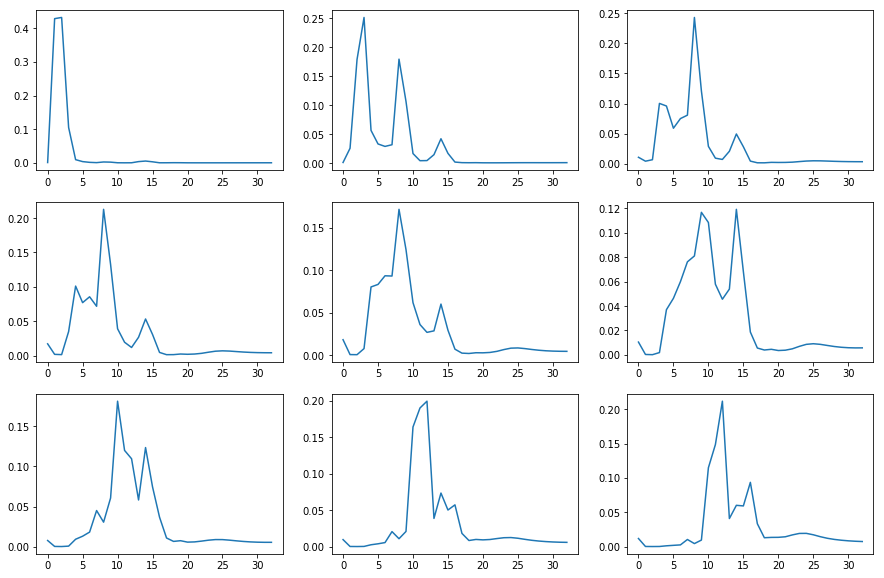

In [74]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
for i,ax in enumerate(axes.flat):
    ax.plot(attn[i])

While building something like this, we don’t really know why it’s not working right.
Early attempts were broken, it wasn’t really learning anything useful. 
It was giving equal attention to everything and it wasn’t worse — it just wasn’t much better. 
When you visualize in a way that you know what it ought to look like ahead of time, 
you don’t really know if it’s working [1:49:16]. 
**NB: is important to find ways to check your intermediate steps in your outputs.**

## All

In [75]:
class Seq2SeqRNN_All(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25, bidirectional=True)
        self.out_enc = nn.Linear(nh*2, em_sz_dec, bias=False)
        self.drop_enc = nn.Dropout(0.25)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data

        self.W1 = rand_p(nh*2, em_sz_dec)
        self.l2 = nn.Linear(em_sz_dec, em_sz_dec)
        self.l3 = nn.Linear(em_sz_dec+nh*2, em_sz_dec)
        self.V = rand_p(em_sz_dec)

    def forward(self, inp, y=None):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        h = h.view(2,2,bs,-1).permute(0,2,1,3).contiguous().view(2,bs,-1)
        h = self.out_enc(self.drop_enc(h))

        dec_inp = V(torch.zeros(bs).long())
        res,attns = [],[]
        w1e = enc_out @ self.W1
        for i in range(self.out_sl):
            w2h = self.l2(h[-1])
            u = F.tanh(w1e + w2h)
            a = F.softmax(u @ self.V, 0)
            attns.append(a)
            Xa = (a.unsqueeze(2) * enc_out).sum(0)
            emb = self.emb_dec(dec_inp)
            wgt_enc = self.l3(torch.cat([emb, Xa], 1))
            
            outp, h = self.gru_dec(wgt_enc.unsqueeze(0), h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
            if (y is not None) and (random.random()<self.pr_force):
                if i>=len(y): break
                dec_inp = y[i]
        return torch.stack(res)

    def initHidden(self, bs): return V(torch.zeros(self.nl*2, bs, self.nh))

In [76]:
rnn = Seq2SeqRNN_All(fr_vecd, fr_itos, dim_fr_vec, en_vecd, en_itos, dim_en_vec, nh, enlen_90)
learn = RNN_Learner(md, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

3097 ['l’', "d'", 't_up', 'd’', "qu'"]
1285 ["'s", '’s', "n't", 'n’t', ':']


In [77]:
cle5 = learn.fit(lr, 1, cycle_len=15, use_clr=(20,10), stepper=Seq2SeqStepper)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      3.464076   10.142172 
    1      3.327786   5.930903                              
    2      3.186693   5.767533                              
    3      3.020956   4.647915                              
    4      2.882753   4.097632                              
    5      2.972992   3.795497                              
    6      2.967739   3.756729                              
    7      2.897926   3.666014                              
    8      2.932456   3.39133                               
    9      3.034467   3.320674                              
    10     2.794008   3.344726                              
    11     2.594886   3.267974                              
    12     2.386572   3.24265                               
    13     2.559441   3.235498                              
    14     2.466764   3.249419                              



### Test

In [78]:
x,y = next(iter(val_dl))
probs = learn.model(V(x))
preds = to_np(probs.max(2)[1])

for i in range(180,190):
    print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in preds[:,i] if o!=1]))
    print()

quelles composantes des différents aspects de la performance devraient être mesurées , quelles données pertinentes recueillir et comment ? _eos_
which components within various performance areas should be measured , whatkinds of data are appropriate to collect , and how should this be done ? _eos_
what components of the performance should be be be be be and and how ? ? _eos_ _eos_

le premier ministre doit - il nommer un ministre d’ état à la santé mentale , à la maladie mentale et à la toxicomanie ? _eos_
what role can the federal government play to ensure that individuals with mental illness and addiction have access to the drug therapy they need ? _eos_
what is the minister minister minister minister minister to to mental mental and mental ? ? ? _eos_

quelles sont les conséquences de la hausse des formes d’ emploi non conformes aux normes chez les travailleurs hautement qualifiés et chez ceux qui occupent des emplois plus marginaux ? _eos_
what is the impact of growing forms of non

In [79]:
t1 = time.clock()
time.ctime(time.time())
t1-t0

8201.050306000001

## END